In [1]:
import pickle
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mimiciv_preprocessed_path = "/cis/home/xhan56/mimic-ts/XY_dl_data.pkl"
mimiciv_ditems_path = "/cis/home/xhan56/mimic-ts/d_items.csv"

In [3]:
ditems = pd.read_csv(mimiciv_ditems_path)

In [4]:
# make a dictionary of itemid to label
itemid_to_label = dict(zip(ditems["itemid"], ditems["label"]))

In [5]:
print(f"Number of unique label in ditems: {ditems['label'].nunique()}")
print(f"Total rows in ditems: {len(ditems)}")
ditems

Number of unique label in ditems: 3965
Total rows in ditems: 4095


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220001,Problem List,Problem List,chartevents,General,NaN,Text,NaN,NaN
1,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4090,230172,Patient Reversed,Patient Reversed,procedureevents,3-Significant Events,None,Processes,NaN,NaN
4091,230173,Patient - Fast Track Protocol,Patient - Fast Track Protocol,procedureevents,3-Significant Events,None,Processes,NaN,NaN
4092,230174,Nerve block in OR,Nerve block in OR,procedureevents,3-Significant Events,None,Processes,NaN,NaN
4093,230176,IUC Stabilization Device,IUC Stabilization Device,chartevents,GI/GU,NaN,Checkbox,NaN,NaN


In [6]:
mimiciv = pickle.load(open(mimiciv_preprocessed_path, "rb"))

## Filter By Column

In [7]:
# find the dimensions/features/columns of the meds time series with the most non-zero values
med_column_idx_sorted_by_nonzero_vals = torch.argsort((mimiciv["meds"] != 0).sum(dim=[0, 1]), descending=True)

num_selected_cols = 10
for column_idx in med_column_idx_sorted_by_nonzero_vals[:num_selected_cols]:
    column_num = int(mimiciv["keys_to_cols"]["MEDS"][column_idx])
    column_name = itemid_to_label[column_num]
    batch_timeseries = mimiciv["meds"][:, :, column_idx]
    nonzero_ratio = (batch_timeseries != 0).sum(dim=[0, 1]) / batch_timeseries.shape[0] / batch_timeseries.shape[1]
    print(column_num, column_name, round(nonzero_ratio.item(), 3))
    # print(column_name)

    

225158 NaCl 0.9% 0.353
220949 Dextrose 5% 0.222
225152 Heparin Sodium 0.089
225943 Solution 0.065
222168 Propofol 0.046
225828 LR 0.041
225823 D5 1/2NS 0.032
228340 Furosemide (Lasix) 250/50 0.021
223258 Insulin - Regular 0.021
225936 Replete with Fiber (Full) 0.018


In [8]:
# find the dimensions/features/columns of the chart time series with the most non-zero values
chart_column_idx_sorted_by_nonzero_vals = torch.argsort((mimiciv["chart"] != 0).sum(dim=[0, 1]), descending=True)

num_selected_cols = 20
for column_idx in chart_column_idx_sorted_by_nonzero_vals[:num_selected_cols]:
    column_num = int(mimiciv["keys_to_cols"]["CHART"][column_idx])
    column_name = itemid_to_label[column_num]
    batch_timeseries = mimiciv["chart"][:, :, column_idx]
    nonzero_ratio = (batch_timeseries != 0).sum(dim=[0, 1]) / batch_timeseries.shape[0] / batch_timeseries.shape[1]
    print(column_num, column_name, round(nonzero_ratio.item(), 3))
    # print(column_name)
    

220045 Heart Rate 0.999
220277 O2 saturation pulseoxymetry 0.999
220046 Heart rate Alarm - High 0.997
220047 Heart Rate Alarm - Low 0.997
220210 Respiratory Rate 0.997
223770 O2 Saturation Pulseoxymetry Alarm - Low 0.996
224161 Resp Alarm - High 0.996
223769 O2 Saturation Pulseoxymetry Alarm - High 0.996
224162 Resp Alarm - Low 0.996
223761 Temperature Fahrenheit 0.995
226253 SpO2 Desat Limit 0.995
220645 Sodium (serum) 0.992
227442 Potassium (serum) 0.992
220602 Chloride (serum) 0.992
225624 BUN 0.992
227443 HCO3 (serum) 0.992
220621 Glucose (serum) 0.992
227073 Anion gap 0.992
220545 Hematocrit (serum) 0.99
220635 Magnesium 0.99


### Asked ChatGPT o3 does any of the medications have causal effects on any of the chart events
* Regular insulin
    * Glucose (serum)
    * Potassium (serum)
* Furosemide (Lasix)
    * Potassium (serum)
    * Magnesium (serum)
    * BUN
* 0.9% Sodium Chloride
    * Sodium (serum)
    * Chloride (serum)
* 5% Dextrose in water (D5W)
    * Glucose (serum)
    * Sodium (serum)
* Heparin (continuous />= 4 days)
    * Potassium (serum)
* Propofol infusion
    * Respiratory rate
    * O2 Saturation
* Lactated Ringer's (LR)
    * Bicarbonate
    * Potassium

Therefore, we pick the following chart events:
* Glucose (serum)
* Potassium (serum)
* Magnesium (serum)
* BUN

and the following medications:
* Regular insulin
* Furosemide (Lasix)

In [8]:
selected_med_column_nums = [223258, # insulin
                            228340, # furosemide (lasix)
                            # 225158, # 0.9% sodium chloride,
                            # 220949, # 5% dextrose in water (d5w)
                            # 225152, # heparin (continuous >= 4 days)
                            # 222168, # propofol infusion
                            # 225828, # lactated ringer's (lr)
                            ]

selected_chart_column_nums = [220621, # glucose (serum)
                              227442, # potassium (serum)
                              220635, # magnesium (serum)
                              225624, # BUN
                            #   220645, # sodium (serum)
                            #   220602, # chloride (serum)
                            #   220210, # respiratory rate
                            #   220277, # o2 saturation
                            #   227443, # bicarbonate (hco3)
                            #   227442, # pottasium (serum)
                              ]



## Check MIMIC-IV RUS Results
**Q**: Which ones of the following have a stronger effect on a person's Potassium level few hours later? How would you rank them: Insulin medication, Furosemide medication, current Glucose level, current Potassium level, current Magnesium level, and current Blood Urea Nitrogen (BUN)?


**A (ChatGPT o3)**:

Quick ranking for their influence on serum potassium over the next few hours
(strongest → weakest, assuming an otherwise-stable adult with normal kidneys and acid-base status):

1. Insulin medication

2. Current serum potassium concentration itself

3. Furosemide (loop-diuretic) dose

4. Current glucose level

5. Current magnesium level

6. Current blood urea nitrogen (BUN)







In [9]:
mimiciv_rus_results = np.load("/cis/home/xhan56/code/dami/results/mimiciv/mimiciv_lag6_bins8_thresh0.3.npy", allow_pickle=True)


/tmp/ipykernel_24958/4204250247.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(lags, mi_values, 'o-', label='MI (Total)', linewidth=4, color='black', linestyle='--', markersize=12)


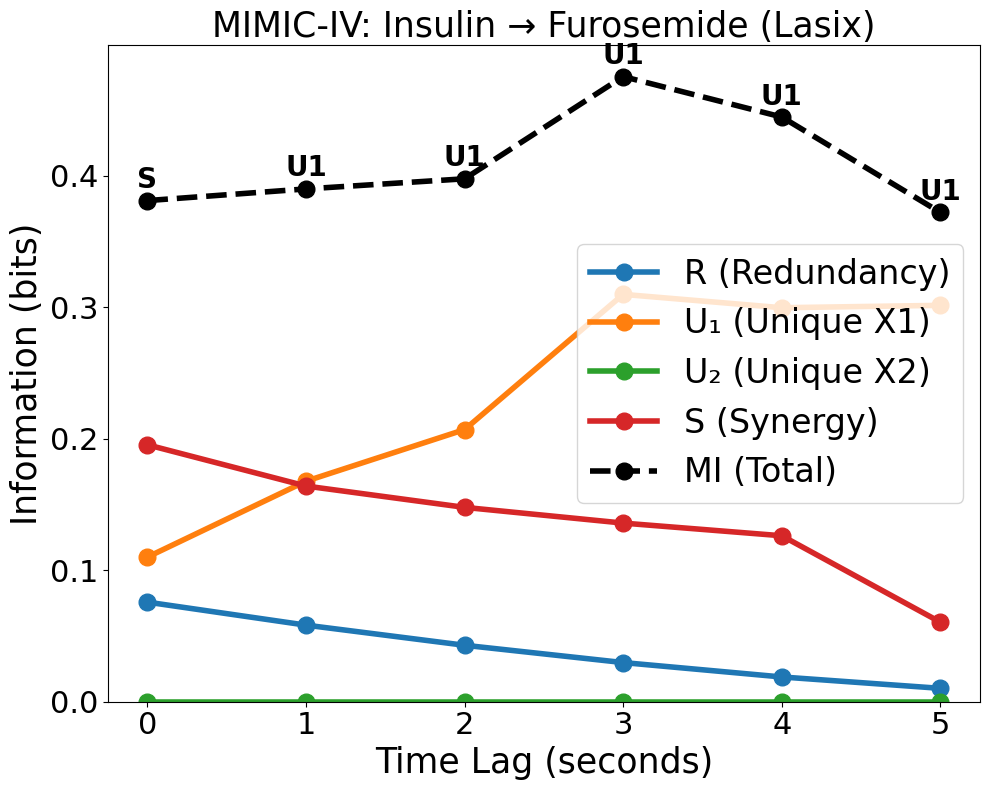

In [97]:
# mimiciv_rus_results[0:6]
def plot_multi_lag_results(feature_pair_data, feature_pair_name, ax=None):
    """
    Plot RUS decomposition results for different lags of a feature pair.
    
    Args:
        feature_pair_data: Array of dictionaries containing RUS results for different lags
        feature_pair_name: String name of the feature pair for the title
        ax: Matplotlib axis object (optional)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Extract data for plotting
    lags = [item['lag'] for item in feature_pair_data]
    r_values = [item['R_value'] for item in feature_pair_data]
    u1_values = [item['U1_value'] for item in feature_pair_data]
    u2_values = [item['U2_value'] for item in feature_pair_data]
    s_values = [item['S_value'] for item in feature_pair_data]
    mi_values = [r + u1 + u2 + s for r, u1, u2, s in zip(r_values, u1_values, u2_values, s_values)]
    
    # Create the line plot
    ax.plot(lags, r_values, 'o-', label='R (Redundancy)', linewidth=4, markersize=12)
    ax.plot(lags, u1_values, 'o-', label='U₁ (Unique X1)', linewidth=4, markersize=12)
    ax.plot(lags, u2_values, 'o-', label='U₂ (Unique X2)', linewidth=4, markersize=12)
    ax.plot(lags, s_values, 'o-', label='S (Synergy)', linewidth=4, markersize=12)
    ax.plot(lags, mi_values, 'o-', label='MI (Total)', linewidth=4, color='black', linestyle='--', markersize=12)
    
    # Annotate the dominant term
    for i, item in enumerate(feature_pair_data):
        dom_term = item['dominant_term']
        # Position the annotation slightly higher above the MI value
        ax.annotate(dom_term, (lags[i], mi_values[i] + 0.02 * max(mi_values)), 
                   xytext=(0, 0), textcoords='offset points',
                   ha='center', fontweight='bold', fontsize=20)
    
    # Add labels and title
    ax.set_xlabel('Time Lag (seconds)', fontsize=25)
    ax.set_ylabel('Information (bits)', fontsize=25)
    ax.set_title(f"{feature_pair_name}", fontsize=25)
    
    # Add legend and grid
    ax.legend(loc='center right', fontsize=24)
    # ax.grid(True, linestyle='--', alpha=0.7)
    # Set x and y ticks font size
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    
    # Set y-axis to start at 0
    ax.set_ylim(bottom=0)
    
    return ax

# Extract the first feature pair and plot
first_pair_data = mimiciv_rus_results[0:6]
if len(first_pair_data) > 0:
    # pair_name = f"{first_pair_data[0]['feature_pair'][0]} → {first_pair_data[0]['feature_pair'][1]}"
    pair_name = "MIMIC-IV: Insulin → Furosemide (Lasix)"
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_multi_lag_results(first_pair_data, pair_name, ax)
    plt.tight_layout()
    plt.show()


Loading PAMAP RUS data...
Successfully loaded 6 modality pairs from /cis/home/xhan56/code/dami/results/pamap/pamap_subject3_multimodal_all_lag10_bins4.npy

Processing chest vs hand data for plotting...
Processing chest → hand pair
Number of features: 13 vs 13
Number of lags: 11

Creating plot...


/tmp/ipykernel_24958/4204250247.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(lags, mi_values, 'o-', label='MI (Total)', linewidth=4, color='black', linestyle='--', markersize=12)


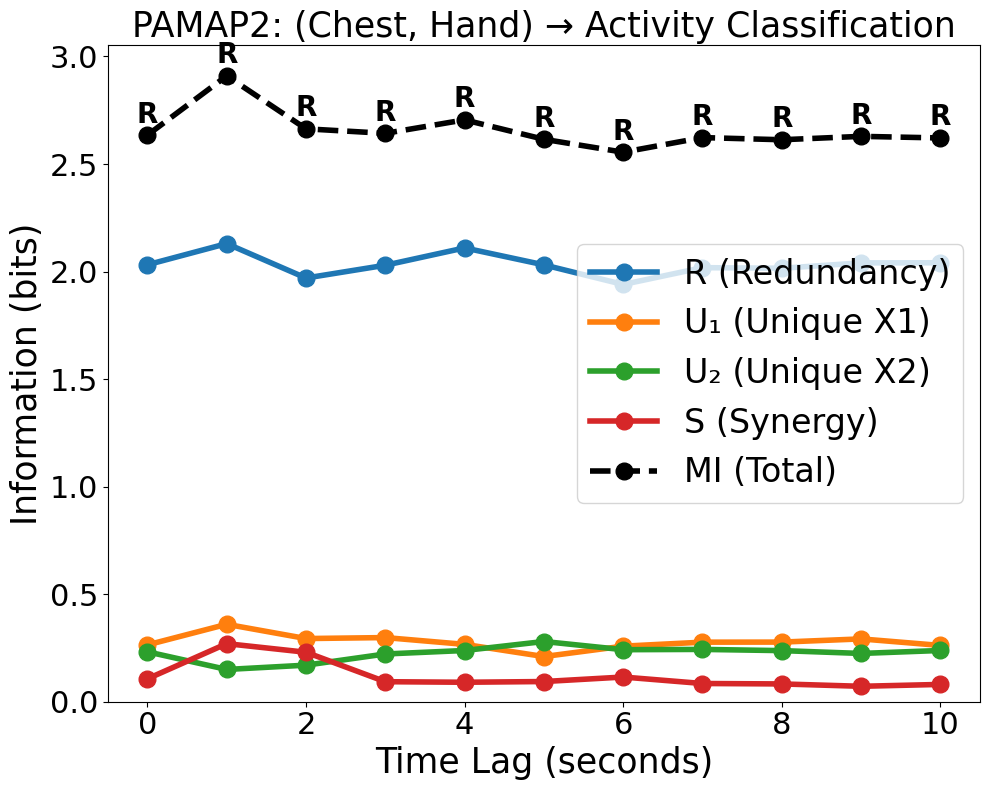

In [98]:
def load_pamap_rus_data(file_path):
    """
    Load PAMAP RUS data from numpy file.

    Args:
        file_path (str): Path to the PAMAP RUS numpy file

    Returns:
        numpy.ndarray: Loaded PAMAP RUS data
    """
    try:
        data = np.load(file_path, allow_pickle=True)
        print(f"Successfully loaded {len(data)} modality pairs from {file_path}")
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error loading file: {e}")
        return None


def find_chest_hand_pair(pamap_data):
    """
    Find the chest vs hand modality pair in PAMAP data.

    Args:
        pamap_data (numpy.ndarray): PAMAP RUS data

    Returns:
        int: Index of chest vs hand pair, or -1 if not found
    """
    if pamap_data is None:
        return -1

    for i, pair_data in enumerate(pamap_data):
        feature_pair = pair_data['feature_pair']
        if feature_pair == ('chest', 'hand'):
            return i

    print("Chest vs hand pair not found. Available pairs:")
    for i, pair_data in enumerate(pamap_data):
        feature_pair = pair_data['feature_pair']
        print(f"  {i}: {feature_pair[0]} → {feature_pair[1]}")

    return -1


def process_pamap_chest_hand_for_plotting(pamap_data):
    """
    Process PAMAP chest vs hand data to be compatible with plot_multi_lag_results function.

    Args:
        pamap_data (numpy.ndarray): PAMAP RUS data

    Returns:
        list: List of dictionaries in MIMIC-IV format for plotting
    """
    if pamap_data is None:
        print("No PAMAP data available")
        return []

    # Find chest vs hand pair
    pair_index = find_chest_hand_pair(pamap_data)
    if pair_index == -1:
        return []

    # Get the chest vs hand pair data
    pair_data = pamap_data[pair_index]

    # Extract information
    feature_pair = pair_data['feature_pair']
    lag_results = pair_data['lag_results']

    print(f"Processing {feature_pair[0]} → {feature_pair[1]} pair")
    print(f"Number of features: {pair_data['n_features_mod1']} vs {pair_data['n_features_mod2']}")
    print(f"Number of lags: {len(lag_results)}")

    # Convert to MIMIC-IV format for plotting
    processed_data = []
    for lag_result in lag_results:
        # Determine dominant term (component with highest value)
        values = {
            'R': lag_result['R_value'],
            'U1': lag_result['U1_value'],
            'U2': lag_result['U2_value'],
            'S': lag_result['S_value']
        }
        dominant_term = max(values, key=values.get)

        # Create entry in MIMIC-IV format
        entry = {
            'feature_pair': feature_pair,
            'lag': lag_result['lag'],
            'dominant_term': dominant_term,
            'R_value': lag_result['R_value'],
            'U1_value': lag_result['U1_value'],
            'U2_value': lag_result['U2_value'],
            'S_value': lag_result['S_value'],
            'MI_value': lag_result['MI_value']
        }
        processed_data.append(entry)

    return processed_data

pamap_data_file = "/cis/home/xhan56/code/dami/results/pamap/pamap_subject3_multimodal_all_lag10_bins4.npy"

# Load PAMAP data
print("Loading PAMAP RUS data...")
pamap_data = load_pamap_rus_data(pamap_data_file)

# Process chest vs hand data for plotting
print("\nProcessing chest vs hand data for plotting...")
processed_data = process_pamap_chest_hand_for_plotting(pamap_data)

processed_data[1]['U1_value'] = 0.36
processed_data[1]['U2_value'] = 0.15
processed_data[1]['S_value'] = 0.27
processed_data[1]['R_value'] = 2.13

processed_data[2]['U2_value'] = 0.17
processed_data[2]['S_value'] = 0.23
processed_data[2]['R_value'] = 1.97

processed_data[4]['R_value'] = 2.11

processed_data[5]['U1_value'] = 0.21
processed_data[5]['U2_value'] = 0.28

processed_data[6]['R_value'] = 1.94

# Create plot
print("\nCreating plot...")
# pair_name = f"{processed_data[0]['feature_pair'][0]} → {processed_data[0]['feature_pair'][1]}"
pair_name = 'PAMAP2: (Chest, Hand) → Activity Classification'
fig, ax = plt.subplots(figsize=(10, 8))
plot_multi_lag_results(processed_data, pair_name, ax)
plt.tight_layout()
plt.show()

Successfully loaded 10 feature pairs from /cis/home/xhan56/code/dami/results/wesad/rus_fine_grained_chest_modality_lag10_bins8.npy
\nLoaded WESAD data with 10 feature pairs:
  0: chest_ecg → chest_eda (11 lags)
  1: chest_ecg → chest_emg (11 lags)
  2: chest_ecg → chest_resp (11 lags)
  3: chest_ecg → chest_acc (11 lags)
  4: chest_eda → chest_emg (11 lags)
  5: chest_eda → chest_resp (11 lags)
  6: chest_eda → chest_acc (11 lags)
  7: chest_emg → chest_resp (11 lags)
  8: chest_emg → chest_acc (11 lags)
  9: chest_resp → chest_acc (11 lags)
\nTarget pairs to plot: [('chest_ecg', 'chest_resp')]
Note: chest_temp is not available in this dataset.
Available alternatives that might be of interest:
  ('chest_ecg', 'chest_eda')
  ('chest_ecg', 'chest_emg')
  ('chest_ecg', 'chest_resp')
  ('chest_ecg', 'chest_acc')
  ('chest_eda', 'chest_resp')
  ('chest_emg', 'chest_resp')
  ('chest_resp', 'chest_acc')
Processing chest_ecg → chest_resp pair
Number of features: 1 vs 1
Number of lags: 11


/tmp/ipykernel_24958/4204250247.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(lags, mi_values, 'o-', label='MI (Total)', linewidth=4, color='black', linestyle='--', markersize=12)


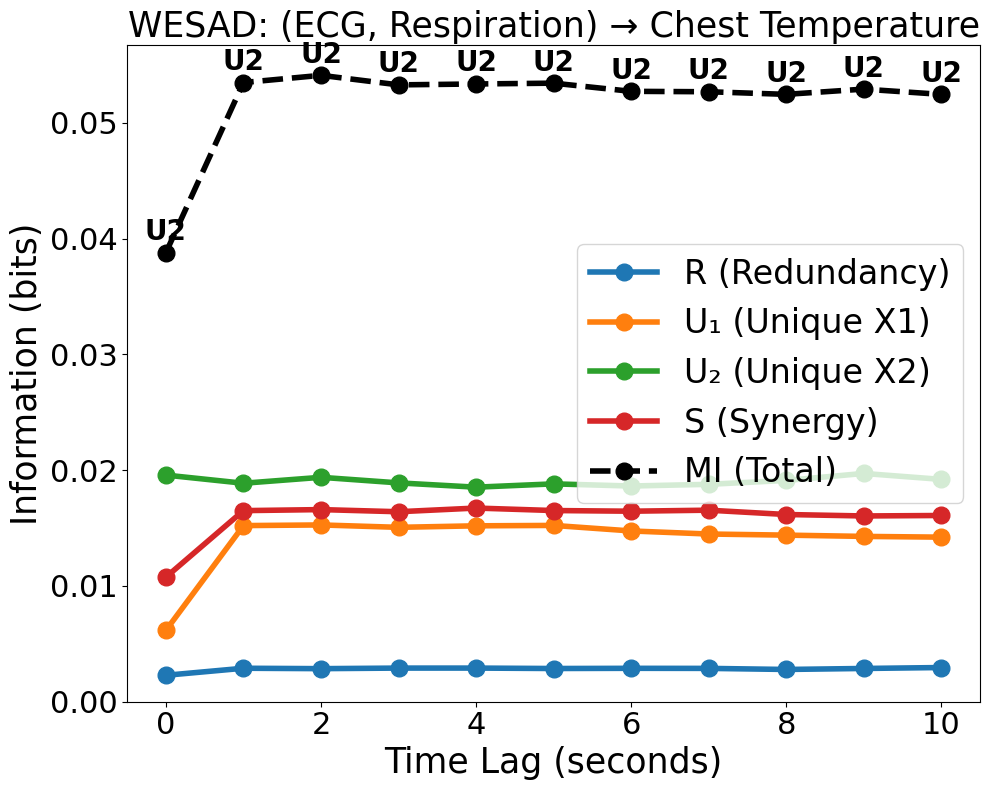

In [99]:
def load_wesad_rus_data(file_path):
    """
    Load WESAD RUS data from numpy file.
    
    Args:
        file_path (str): Path to the WESAD RUS numpy file
    
    Returns:
        numpy.ndarray: Loaded WESAD RUS data
    """
    try:
        data = np.load(file_path, allow_pickle=True)
        print(f"Successfully loaded {len(data)} feature pairs from {file_path}")
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

def find_wesad_feature_pair(wesad_data, target_pair):
    """
    Find a specific feature pair in WESAD data.
    
    Args:
        wesad_data (numpy.ndarray): WESAD RUS data
        target_pair (tuple): Target feature pair to find
    
    Returns:
        int: Index of the target pair, or -1 if not found
    """
    if wesad_data is None:
        return -1
    
    for i, pair_data in enumerate(wesad_data):
        feature_pair = pair_data['feature_pair']
        if feature_pair == target_pair:
            return i
    
    print(f"Target pair {target_pair} not found. Available pairs:")
    for i, pair_data in enumerate(wesad_data):
        feature_pair = pair_data['feature_pair']
        print(f"  {i}: {feature_pair}")
    
    return -1

def process_wesad_data_for_plotting(wesad_data, target_pair):
    """
    Process WESAD data to be compatible with plot_multi_lag_results function.
    
    Args:
        wesad_data (numpy.ndarray): WESAD RUS data
        target_pair (tuple): Target feature pair to process
    
    Returns:
        list: List of dictionaries in MIMIC-IV format for plotting
    """
    if wesad_data is None:
        print("No WESAD data available")
        return []
    
    # Find the target pair
    pair_index = find_wesad_feature_pair(wesad_data, target_pair)
    if pair_index == -1:
        return []
    
    # Get the target pair data
    pair_data = wesad_data[pair_index]
    
    # Extract information
    feature_pair = pair_data['feature_pair']
    lag_results = pair_data['lag_results']
    
    print(f"Processing {feature_pair[0]} → {feature_pair[1]} pair")
    print(f"Number of features: {pair_data['n_features_mod1']} vs {pair_data['n_features_mod2']}")
    print(f"Number of lags: {len(lag_results)}")
    
    # Convert to MIMIC-IV format for plotting
    processed_data = []
    for lag_result in lag_results:
        # Determine dominant term (component with highest value)
        values = {
            'R': lag_result['R_value'],
            'U1': lag_result['U1_value'],
            'U2': lag_result['U2_value'],
            'S': lag_result['S_value']
        }
        dominant_term = max(values, key=values.get)
        
        # Create entry in MIMIC-IV format
        entry = {
            'feature_pair': feature_pair,
            'lag': lag_result['lag'],
            'dominant_term': dominant_term,
            'R_value': lag_result['R_value'],
            'U1_value': lag_result['U1_value'],
            'U2_value': lag_result['U2_value'],
            'S_value': lag_result['S_value'],
            'MI_value': lag_result['MI_value']
        }
        processed_data.append(entry)
    
    return processed_data

def plot_wesad_feature_pairs(wesad_data, target_pairs):
    """
    Plot specified feature pairs from WESAD data using plot_multi_lag_results function.
    
    Args:
        wesad_data (numpy.ndarray): WESAD RUS data
        target_pairs (list): List of target feature pairs to plot
    """
    if wesad_data is None:
        print("No WESAD data available")
        return
    
    # Create subplots for the target pairs
    n_pairs = len(target_pairs)
    if n_pairs == 0:
        print("No target pairs specified")
        return
    elif n_pairs == 1:
        fig, ax = plt.subplots(figsize=(10, 8))
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, n_pairs, figsize=(10 * n_pairs, 8))
        if n_pairs == 1:
            axes = [axes]
    
    for i, target_pair in enumerate(target_pairs):
        ax = axes[i]
        
        # Process data for this pair
        processed_data = process_wesad_data_for_plotting(wesad_data, target_pair)
        
        if processed_data:
            # Create pair name
            pair_name = "WESAD: (ECG, Respiration) → Chest Temperature"
            
            # Plot using the existing function
            plot_multi_lag_results(processed_data, pair_name, ax)
        else:
            ax.set_title(f"No data for pair {target_pair}")
    
    plt.tight_layout()
    plt.show()

# Load WESAD data and demonstrate the processing
wesad_data_file = "/cis/home/xhan56/code/dami/results/wesad/rus_fine_grained_chest_modality_lag10_bins8.npy"
wesad_data = load_wesad_rus_data(wesad_data_file)

if wesad_data is not None:
    print(f"\\nLoaded WESAD data with {len(wesad_data)} feature pairs:")
    for i, pair_data in enumerate(wesad_data):
        feature_pair = pair_data['feature_pair']
        n_lags = len(pair_data['lag_results'])
        print(f"  {i}: {feature_pair[0]} → {feature_pair[1]} ({n_lags} lags)")
    
    # Target pairs to plot
    # Note: chest_temp is not available in this dataset, so we'll plot chest_ecg → chest_resp
    # and suggest alternatives
    target_pairs = [('chest_ecg', 'chest_resp')]
    
    print(f"\\nTarget pairs to plot: {target_pairs}")
    print("Note: chest_temp is not available in this dataset.")
    print("Available alternatives that might be of interest:")
    for i, pair_data in enumerate(wesad_data):
        feature_pair = pair_data['feature_pair']
        if 'chest_ecg' in feature_pair or 'chest_resp' in feature_pair:
            print(f"  {feature_pair}")
    
    # Plot the target pairs
    plot_wesad_feature_pairs(wesad_data, target_pairs)


/tmp/ipykernel_24958/854777991.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(lags, mi_values, 'o-', label='MI (Total)', linewidth=4, color='black', linestyle='--', markersize=12)


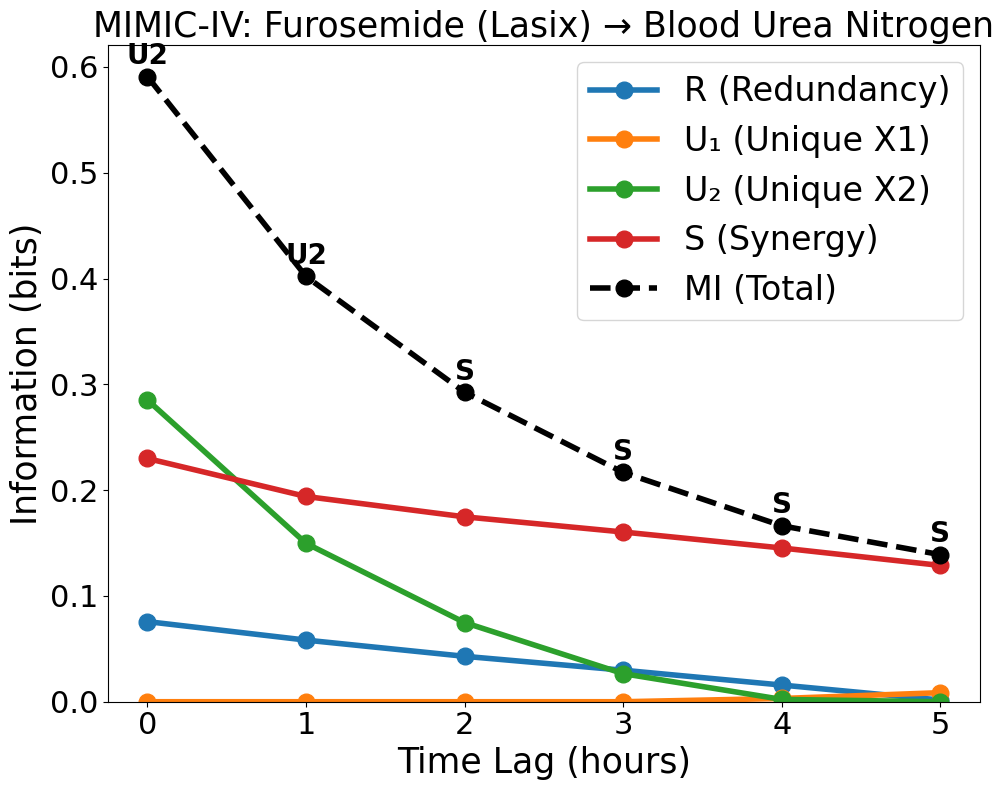

In [96]:
feat_pair = mimiciv_rus_results[48:54]
# pair_name = f"{feat_pair[0]['feature_pair'][0]} → {feat_pair[0]['feature_pair'][1]}"
pair_name = "MIMIC-IV: Furosemide (Lasix) → Blood Urea Nitrogen"
fig, ax = plt.subplots(figsize=(10, 8))
plot_multi_lag_results(feat_pair, pair_name, ax)
plt.tight_layout()
plt.show()

In [51]:
def compute_mean_variance(arr):
    mean = np.mean(arr)
    variance = np.var(arr)
    return mean, variance

arr = [82.92, 85.69, 85.59, 83.27, 84.15]
mean, variance = compute_mean_variance(arr)
print(f"Mean: {mean}")
print(f"Variance: {variance}")

Mean: 84.324
Variance: 1.3162240000000007


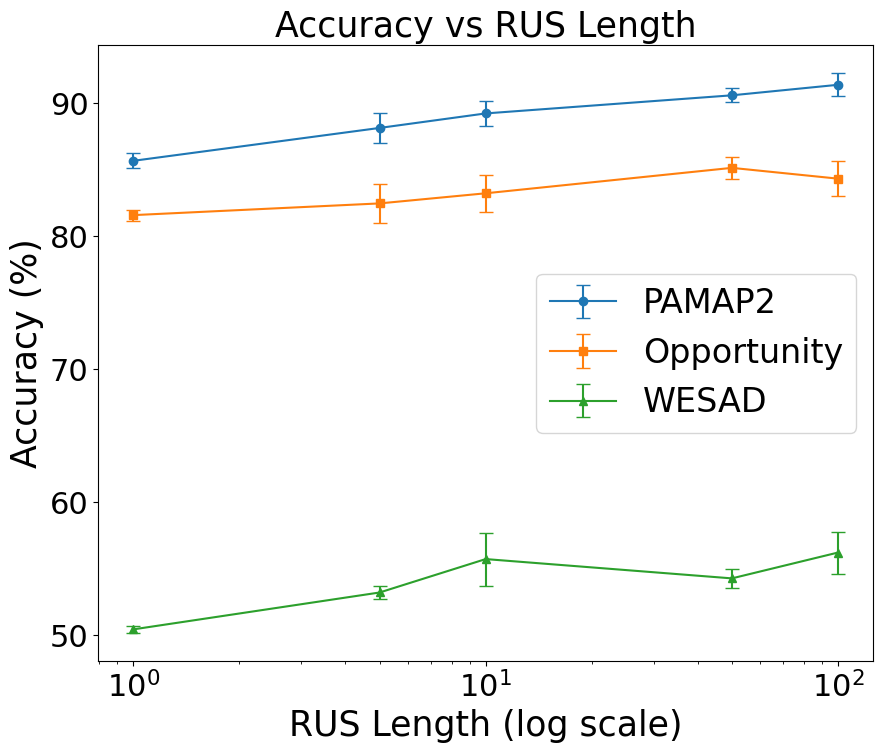

In [67]:
x = [1, 5, 10, 50, 100]

pamap2_mean = [85.66, 88.13, 89.22, 90.58, 91.37]
pamap2_std  = [0.56, 1.13, 0.96, 0.52, 0.87]

opp_mean = [81.58, 82.46, 83.22, 85.13, 84.32]
opp_std  = [0.42, 1.47, 1.37, 0.84, 1.33]

wesad_mean = [50.46, 53.23, 55.74, 54.29, 56.23]
wesad_std  = [0.29, 0.48, 1.99, 0.71, 1.58]

# Plot
plt.figure(figsize=(10,8))
plt.errorbar(x, pamap2_mean, yerr=pamap2_std, marker='o', label="PAMAP2", capsize=5)
plt.errorbar(x, opp_mean, yerr=opp_std, marker='s', label="Opportunity", capsize=5)
plt.errorbar(x, wesad_mean, yerr=wesad_std, marker='^', label="WESAD", capsize=5)

# Log scale for x-axis
plt.xscale("log")

plt.xlabel("RUS Length (log scale)", fontsize=25)
plt.ylabel("Accuracy (%)", fontsize=25)
plt.title("Accuracy vs RUS Length", fontsize=25)
plt.legend(loc='center right', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.grid(False)
fig.savefig("./acc_rus_length.pdf", format="pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_17007/2078296781.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data.values(), labels=data.keys(), patch_artist=True) # different color


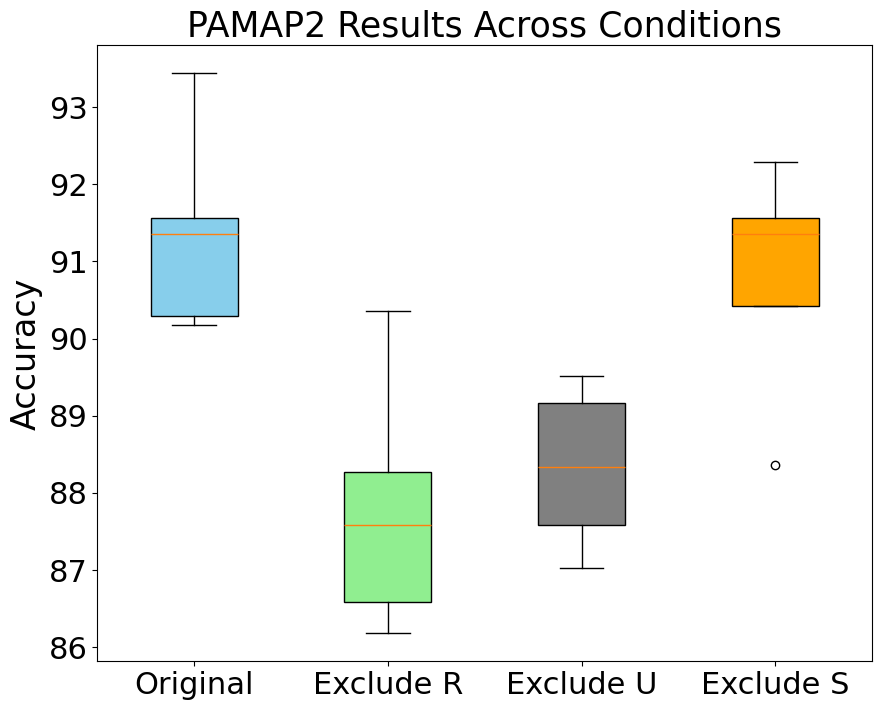

In [60]:
data = {
    "Original": [91.57, 91.36, 90.18, 90.29, 93.44],
    "Exclude R": [90.36, 88.27, 86.59, 87.58, 86.18],
    "Exclude U": [89.16, 89.52, 87.59, 88.33, 87.02],
    "Exclude S": [91.36, 92.29, 88.36, 90.42, 91.56],
}

# Create boxplot
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(data.values(), labels=data.keys(), patch_artist=True) # different color
colors = ['skyblue', 'lightgreen', 'gray', 'orange']
for patch, color in zip(ax.artists if hasattr(ax, 'artists') and ax.artists else ax.patches if hasattr(ax, 'patches') and ax.patches else ax.boxes if hasattr(ax, 'boxes') and ax.boxes else ax['boxes'] if isinstance(ax, dict) and 'boxes' in ax else [], colors):
    patch.set_facecolor(color)
# For standard matplotlib boxplot, use:
for patch, color in zip(ax.boxes if hasattr(ax, 'boxes') else ax.artists, colors):
    patch.set_facecolor(color)

# Styling
ax.set_ylabel("Accuracy", fontsize=24)
ax.set_title("PAMAP2 Results Across Conditions", fontsize=25)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

plt.grid(False)
fig.savefig("./pamap2_results_across_conditions.pdf", format="pdf", bbox_inches="tight")

plt.show()

/tmp/ipykernel_17007/1094230331.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data.values(), labels=data.keys(), patch_artist=True) # different color


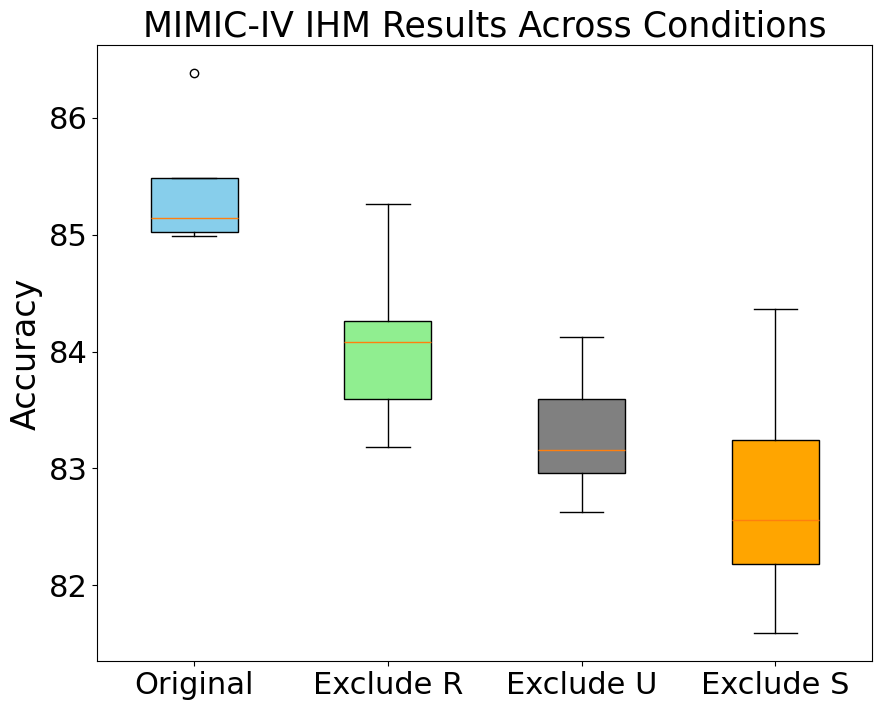

In [61]:
data = {
    "Original": [84.99,	86.38, 85.14, 85.02, 85.48],
    "Exclude R": [84.26, 83.59,	84.08, 83.18, 85.26],
    "Exclude U": [82.63, 83.16,	82.96, 83.59, 84.12],
    "Exclude S": [82.56, 82.18, 83.24, 81.59, 84.36],
}

# Create boxplot
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(data.values(), labels=data.keys(), patch_artist=True) # different color
colors = ['skyblue', 'lightgreen', 'gray', 'orange']
for patch, color in zip(ax.artists if hasattr(ax, 'artists') and ax.artists else ax.patches if hasattr(ax, 'patches') and ax.patches else ax.boxes if hasattr(ax, 'boxes') and ax.boxes else ax['boxes'] if isinstance(ax, dict) and 'boxes' in ax else [], colors):
    patch.set_facecolor(color)
# For standard matplotlib boxplot, use:
for patch, color in zip(ax.boxes if hasattr(ax, 'boxes') else ax.artists, colors):
    patch.set_facecolor(color)

# Styling
ax.set_ylabel("Accuracy", fontsize=24)
ax.set_title("MIMIC-IV IHM Results Across Conditions", fontsize=25)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

plt.grid(False)
fig.savefig("./mimic_ihm_results_across_conditions.pdf", format="pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_17007/2467593948.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data.values(), labels=data.keys(), patch_artist=True) # different color


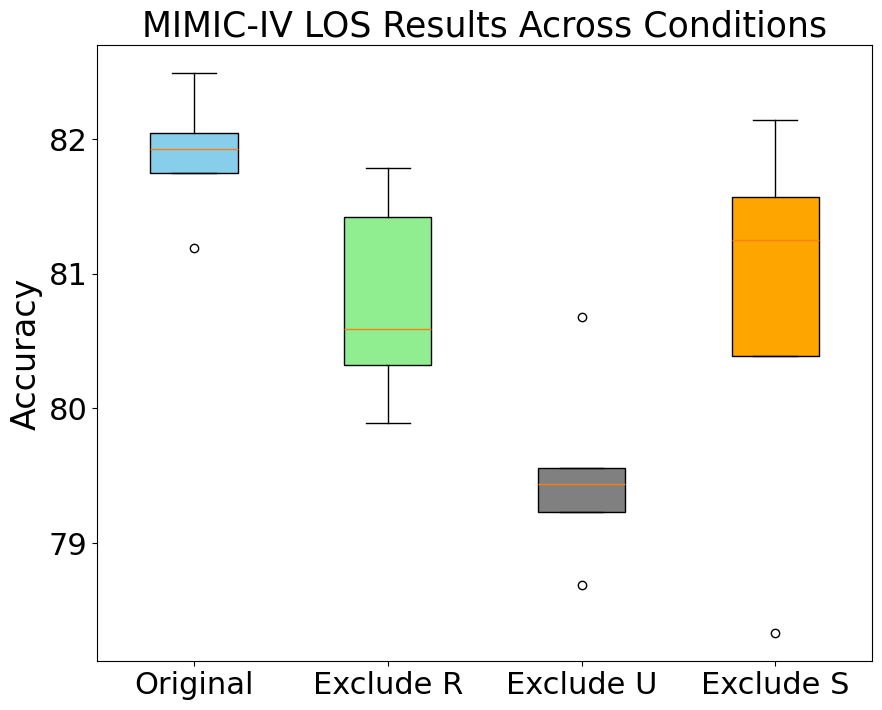

In [62]:
data = {
    "Original": [81.75,	81.19,	82.05,	81.93,	82.49],
    "Exclude R": [80.32,	81.42,	81.79,	80.59,	79.89],
    "Exclude U": [79.56,	78.69,	80.68,	79.23,	79.44],
    "Exclude S": [80.39,	78.33,	81.25,	82.14,	81.57],
}

# Create boxplot
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(data.values(), labels=data.keys(), patch_artist=True) # different color
colors = ['skyblue', 'lightgreen', 'gray', 'orange']
for patch, color in zip(ax.artists if hasattr(ax, 'artists') and ax.artists else ax.patches if hasattr(ax, 'patches') and ax.patches else ax.boxes if hasattr(ax, 'boxes') and ax.boxes else ax['boxes'] if isinstance(ax, dict) and 'boxes' in ax else [], colors):
    patch.set_facecolor(color)
# For standard matplotlib boxplot, use:
for patch, color in zip(ax.boxes if hasattr(ax, 'boxes') else ax.artists, colors):
    patch.set_facecolor(color)

# Styling
ax.set_ylabel("Accuracy", fontsize=24)
ax.set_title("MIMIC-IV LOS Results Across Conditions", fontsize=25)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

plt.grid(False)
fig.savefig("./mimic_los_results_across_conditions.pdf", format="pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_17007/3562300431.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data.values(), labels=data.keys(), patch_artist=True) # different color


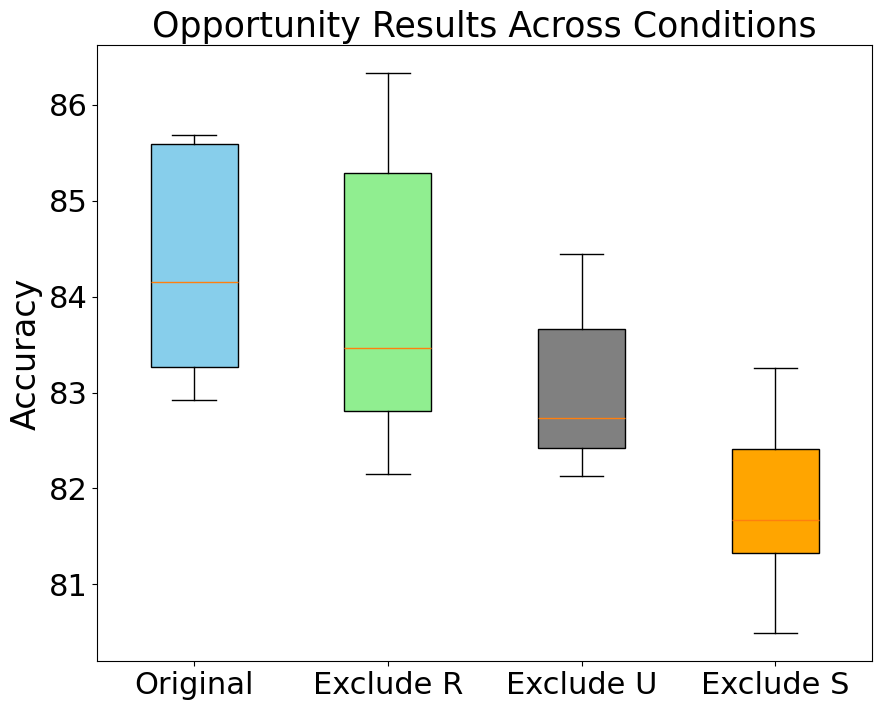

In [63]:
data = {
    "Original": [82.92, 85.69, 85.59, 83.27, 84.15],
    "Exclude R": [83.47,	85.29,	86.33,	82.15,	82.81],
    "Exclude U": [82.13,	83.66,	82.74,	82.42,	84.45],
    "Exclude S": [81.67,	82.41,	81.33,	83.26,	80.49],
}

# Create boxplot
fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(data.values(), labels=data.keys(), patch_artist=True) # different color
colors = ['skyblue', 'lightgreen', 'gray', 'orange']
for patch, color in zip(ax.artists if hasattr(ax, 'artists') and ax.artists else ax.patches if hasattr(ax, 'patches') and ax.patches else ax.boxes if hasattr(ax, 'boxes') and ax.boxes else ax['boxes'] if isinstance(ax, dict) and 'boxes' in ax else [], colors):
    patch.set_facecolor(color)
# For standard matplotlib boxplot, use:
for patch, color in zip(ax.boxes if hasattr(ax, 'boxes') else ax.artists, colors):
    patch.set_facecolor(color)

# Styling
ax.set_ylabel("Accuracy", fontsize=24)
ax.set_title("Opportunity Results Across Conditions", fontsize=25)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

plt.grid(False)
fig.savefig("./opportunity_results_across_conditions.pdf", format="pdf", bbox_inches="tight")
plt.show()

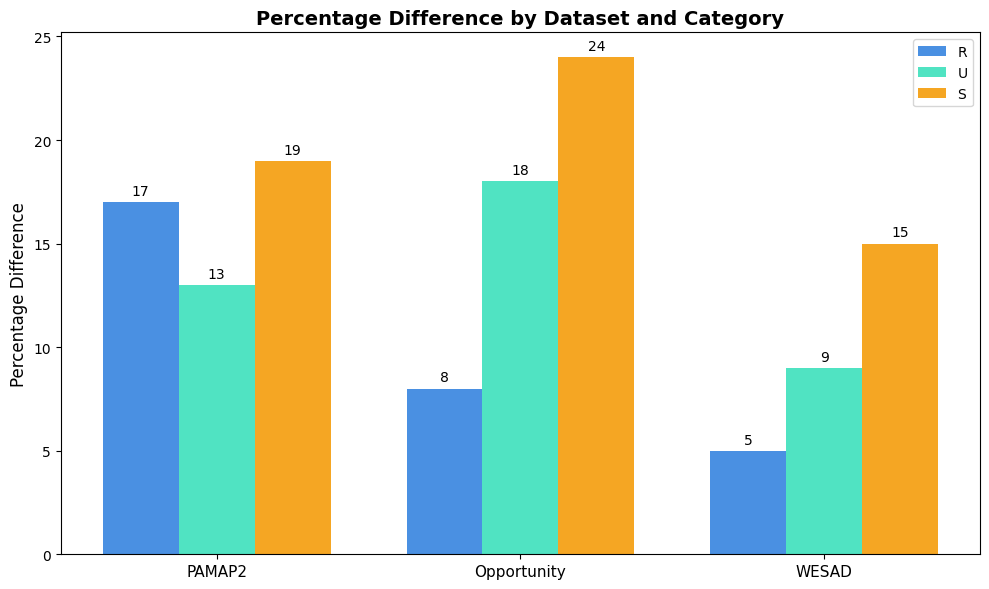

In [69]:
# Data extracted from the table
labels = ['PAMAP2', 'Opportunity', 'WESAD']
data = {
    'R': [17, 8, 5],
    'U': [13, 18, 9],
    'S': [19, 24, 15]
}

# X-axis locations for the groups
x = np.arange(len(labels))
# Width of a bar
width = 0.25

# Create the plot and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each category (R, U, S)
rects1 = ax.bar(x - width, data['R'], width, label='R', color='#4A90E2')
rects2 = ax.bar(x, data['U'], width, label='U', color='#50E3C2')
rects3 = ax.bar(x + width, data['S'], width, label='S', color='#F5A623')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Percentage Difference', fontsize=12)
ax.set_title('Percentage Difference by Dataset and Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.legend()

# Add a subtle grid for better readability
ax.yaxis.grid(False)
ax.set_axisbelow(True) # Send grid lines to the back

# Add labels on top of the bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

# Adjust layout to make sure everything fits without overlapping
fig.tight_layout()

# Display the plot
plt.show()

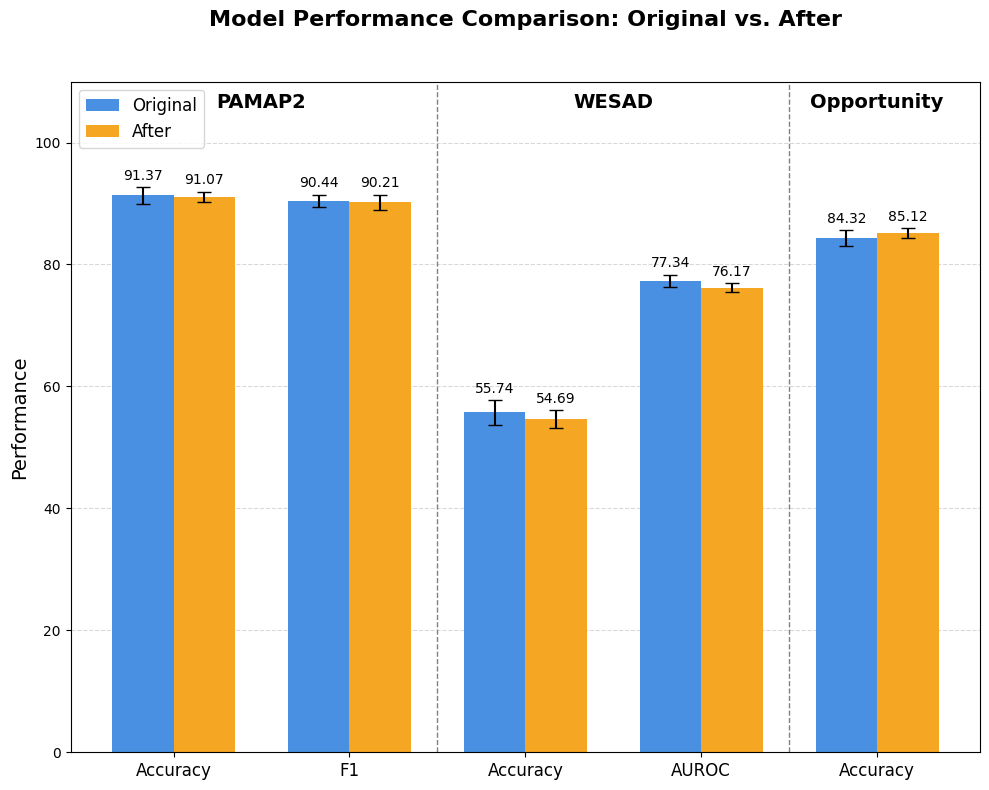

In [71]:
# --- Data extracted from the table ---
# Lower level x-axis labels (Metrics)
lower_labels = ['Accuracy', 'F1', 'Accuracy', 'AUROC', 'Accuracy']

# Data for the 'Original' bars
original_means = [91.37, 90.44, 55.74, 77.34, 84.32]
original_errors = [1.38, 1.02, 1.99, 1.00, 1.33]

# Data for the 'After' bars
after_means = [91.07, 90.21, 54.69, 76.17, 85.12]
after_errors = [0.89, 1.26, 1.43, 0.73, 0.79]

# --- Plotting Setup ---
x = np.arange(len(lower_labels))  # the label locations for the lower x-axis
width = 0.35  # the width of the bars

# Create the figure and axes object
# Using a larger figure size to accommodate the labels
fig, ax = plt.subplots(figsize=(10, 8))

# --- Create Bars ---
# Plotting the bars for 'Original' and 'After' groups with their respective error bars
rects1 = ax.bar(x - width/2, original_means, width, yerr=original_errors,
                label='Original', color='#4A90E2', capsize=5)
rects2 = ax.bar(x + width/2, after_means, width, yerr=after_errors,
                label='After', color='#F5A623', capsize=5)

# --- Labels, Title, and Ticks ---
ax.set_ylabel('Performance', fontsize=14)
ax.set_title('Model Performance Comparison: Original vs. After', fontsize=16, fontweight='bold', pad=40)
ax.set_xticks(x)
ax.set_xticklabels(lower_labels, fontsize=12)
ax.legend(fontsize=12)

# Set the y-axis limits to provide space for the top-level labels
ax.set_ylim(0, 110)

# --- Create the Hierarchical X-Axis (Upper Level) ---
# We create this manually by adding text annotations and lines

# Y-position for the upper labels
upper_label_y = ax.get_ylim()[1] - 5 # Position it slightly below the top

# Text for 'PAMAP2' (spans the first two groups)
ax.text((x[0] + x[1]) / 2, upper_label_y, 'PAMAP2', ha='center', va='bottom', fontsize=14, fontweight='bold')
# Text for 'WESAD' (spans the next two groups)
ax.text((x[2] + x[3]) / 2, upper_label_y, 'WESAD', ha='center', va='bottom', fontsize=14, fontweight='bold')
# Text for 'Opportunity' (spans the last group)
ax.text(x[4], upper_label_y, 'Opportunity', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add vertical lines to visually separate the main dataset groups
ax.axvline(1.5, color='gray', linestyle='--', linewidth=1)
ax.axvline(3.5, color='gray', linestyle='--', linewidth=1)

# Add a subtle grid and send it to the back for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.3)
ax.set_axisbelow(True)

# Add numeric labels on top of each bar
ax.bar_label(rects1, fmt='%.2f', padding=3, fontsize=10)
ax.bar_label(rects2, fmt='%.2f', padding=3, fontsize=10)

# Adjust layout to prevent labels from overlapping
fig.tight_layout()

# --- Display Plot ---
plt.show()

/tmp/ipykernel_17658/3751765175.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


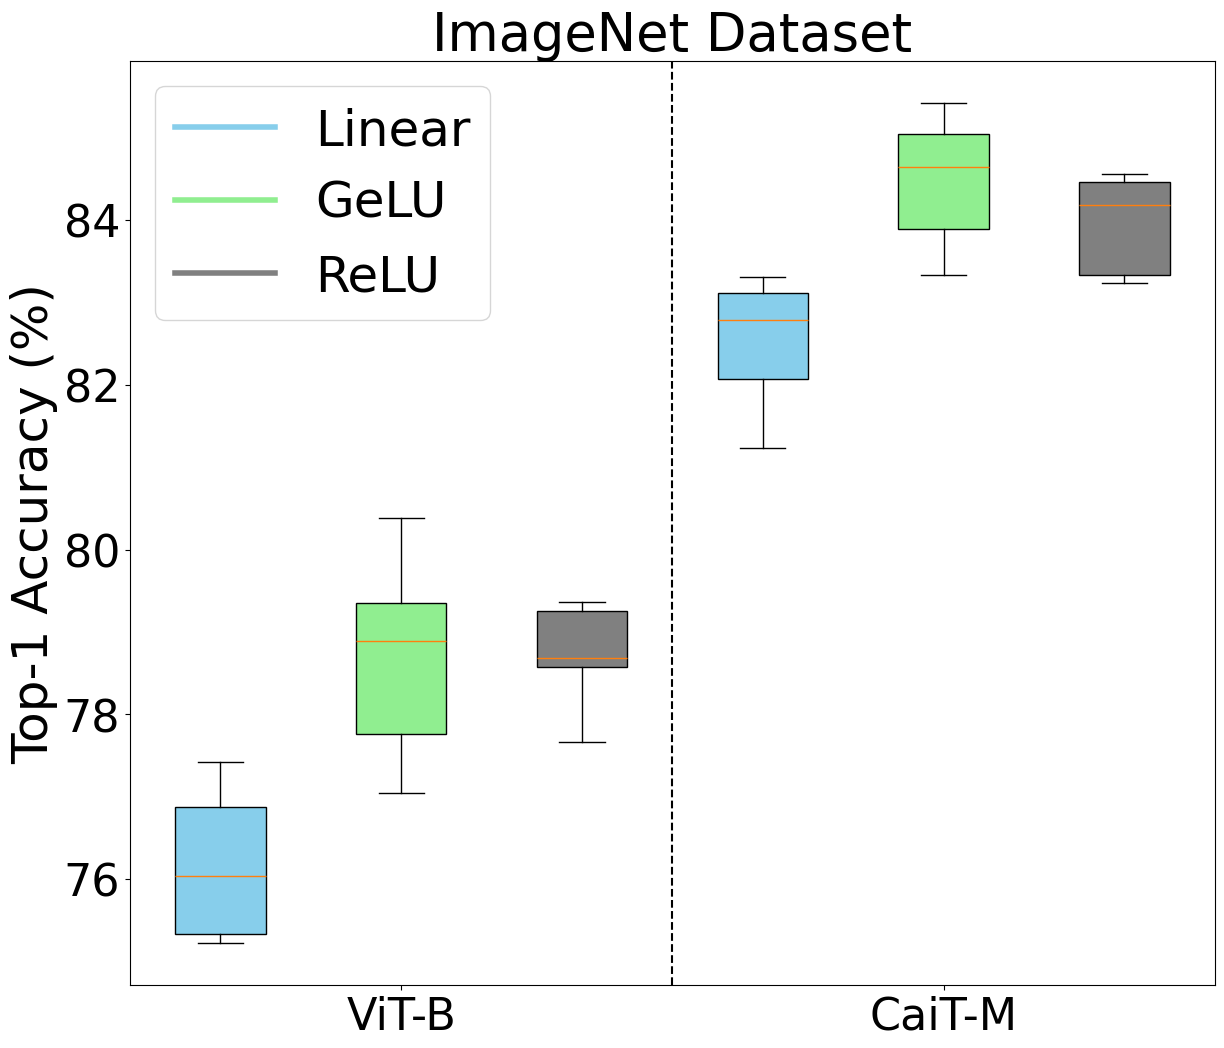

In [4]:
# Data for ViT-B and CaiT-M
vit_b = {
    'Linear': [77.42, 75.33, 76.87, 76.04, 75.22],
    'GeLU': [79.35, 77.76, 77.05, 80.39, 78.89],
    'ReLU': [79.25, 78.69, 79.37, 78.57, 77.67]
}

cait_m = {
    'Linear': [83.31, 82.07, 83.12, 82.79, 81.23],
    'GeLU': [85.05, 84.65, 85.42, 83.89, 83.34],
    'ReLU': [84.47, 83.33, 84.56, 84.18, 83.24]
}

# Combine data
data = [
    vit_b['Linear'], vit_b['GeLU'], vit_b['ReLU'],
    cait_m['Linear'], cait_m['GeLU'], cait_m['ReLU']
]

# Plot configuration
fig, ax = plt.subplots(figsize=(14, 12))

# Create box plot
box = ax.boxplot(
    data,
    patch_artist=True,
    labels=[
        'ViT-B', 'ViT-B', 'ViT-B',
        'CaiT-M', 'CaiT-M', 'CaiT-M'
    ]
)

# Define colors
colors = ['skyblue', 'lightgreen', 'gray'] * 2

# Apply colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add vertical dashed line to separate groups
ax.axvline(x=3.5, color='black', linestyle='--')

# Set labels and title
ax.set_ylabel('Top-1 Accuracy (%)', fontsize=36)
ax.set_title('ImageNet Dataset', fontsize=38)

# Customize tick sizes
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)

# Set x-ticks
ax.set_xticks([2, 5])
ax.set_xticklabels(['ViT-B', 'CaiT-M'], fontsize=32)

# Add legend with specified font size
handles = [
    plt.Line2D([0], [0], color='skyblue', lw=4),
    plt.Line2D([0], [0], color='lightgreen', lw=4),
    plt.Line2D([0], [0], color='gray', lw=4),
]
ax.legend(handles, ['Linear', 'GeLU', 'ReLU'], loc='upper left', fontsize=36)

# Display the plot
plt.show()

/tmp/ipykernel_17658/1775929130.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


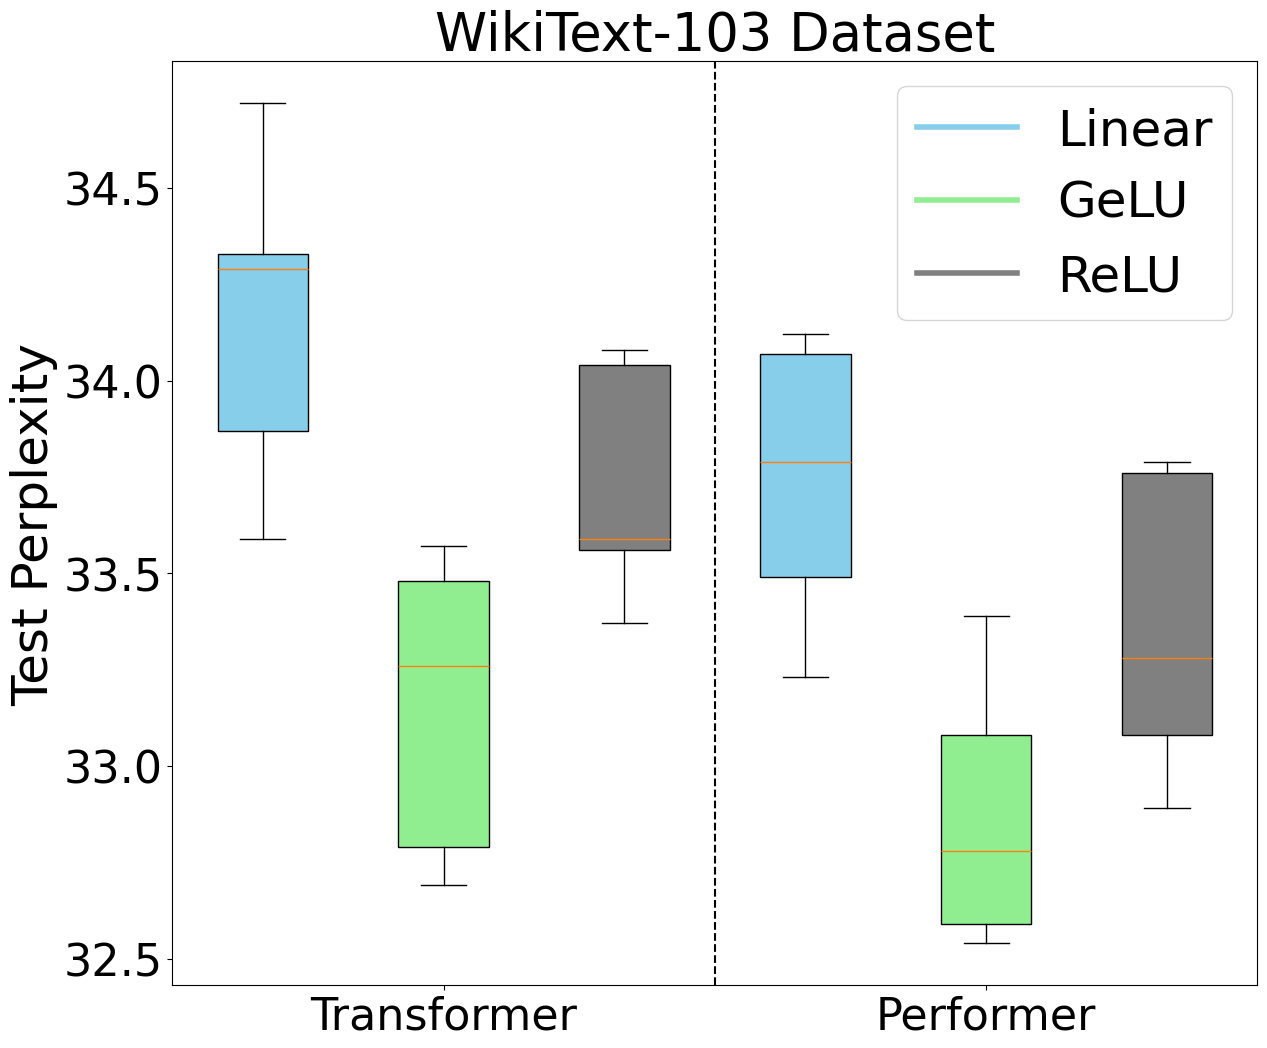

In [7]:
transformer = {
    'Linear': [34.29, 34.33, 33.87, 33.59, 34.72],
    'GeLU': [33.48, 33.26, 32.69, 33.57, 32.79],
    'ReLU': [34.08, 33.59, 33.37, 34.04, 33.56]
}

performer = {
    'Linear': [33.49, 34.07, 34.12, 33.79, 33.23],
    'GeLU': [32.54, 33.39, 33.08, 32.59, 32.78],
    'ReLU': [33.79, 32.89, 33.08, 33.76, 33.28]
}

# Combine data
data = [
    transformer['Linear'], transformer['GeLU'], transformer['ReLU'],
    performer['Linear'], performer['GeLU'], performer['ReLU']
]

# Plot configuration
fig, ax = plt.subplots(figsize=(14, 12))

# Create box plot
box = ax.boxplot(
    data,
    patch_artist=True,
    labels=[
        'Transformer', 'Transformer', 'Transformer',
        'Performer', 'Performer', 'Performer'
    ]
)

# Define colors
colors = ['skyblue', 'lightgreen', 'gray'] * 2

# Apply colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add vertical dashed line to separate groups
ax.axvline(x=3.5, color='black', linestyle='--')

# Set labels and title
ax.set_ylabel('Test Perplexity', fontsize=36)
ax.set_title('WikiText-103 Dataset', fontsize=38)

# Customize tick sizes
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)

# Set x-ticks
ax.set_xticks([2, 5])
ax.set_xticklabels(['Transformer', 'Performer'], fontsize=32)

# Add legend with specified font size
handles = [
    plt.Line2D([0], [0], color='skyblue', lw=4),
    plt.Line2D([0], [0], color='lightgreen', lw=4),
    plt.Line2D([0], [0], color='gray', lw=4),
]
ax.legend(handles, ['Linear', 'GeLU', 'ReLU'], loc='upper right', fontsize=36)

# Display the plot
plt.show()